In [1]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt

import axion_motion
import model
import transport_equation
from common import cosmology, constants, util
from common.rh_neutrino import calc_Gamma_a_SU2
from transport_eq import model as rad_dom_model
from transport_eq import axion_motion as rad_dom_axion_motion

In [2]:
# choose parameter "equivalent" to the paper
T_osc = 4e13
T_RH = 1e12
m_a = 2 * cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T_osc))
print("m_a(T_osc) = %e" % m_a)
m_a = 1e10
# T_dec = 1e11
decay_rate = 0 # cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T_dec))
Gamma_phi = cosmology.calc_inflaton_decay_rate_from_reheating_temperature(T_RH)
H_inf = 1e12 

m_a(T_osc) = 4.496386e+09


In [3]:
m = model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                     axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,), Gamma_phi, H_inf)
m2 = rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                     rad_dom_axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,))

In [4]:
%time ress = model.solve_to_end(m, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, collect=True)
%time ress2 = rad_dom_model.solve_to_end(m2, T_RH, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, collect=True)

CPU times: user 18.8 s, sys: 11.1 ms, total: 18.8 s
Wall time: 18.8 s
CPU times: user 25.4 s, sys: 7.28 ms, total: 25.4 s
Wall time: 25.4 s


Text(0, 0.5, '$\\mu / T$')

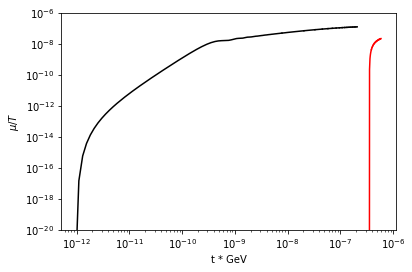

In [5]:
for res, res2 in zip(ress, ress2):
    T = res.T_fn(res.t)
    plt.loglog(res.t, -transport_equation.calc_B_minus_L(res.red_chem_pots), color="black")
    t = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(res2.T)))
    plt.loglog(t, -transport_equation.calc_B_minus_L(res2.red_chem_pots), color="red")
plt.ylim(1e-20, 1e-6)
plt.xlabel("t * GeV")
plt.ylabel(r"$\mu / T$")

In [6]:
"%e" % res2.T[-1]

'7.777172e+11'

In [11]:
m_a_range = np.geomspace(1e6, 1e9, 21)
Gamma_phi_range = np.geomspace(1e6, 1e9, 20)
H_inf = 2e10
f_a = 3e14

In [12]:
%%time
eta_B_rh = [[model.solve(model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                                           axion_motion.calc_d2Vdtheta2_simple, calc_Gamma_a_SU2(m_a, f_a), (m_a,), Gamma_phi, H_inf),
                              (1,0), f_a, calc_axion_mass=axion_motion.calc_const_axion_mass)
                 for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:9: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:12: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


CPU times: user 19min 12s, sys: 76 ms, total: 19min 12s
Wall time: 19min 12s


In [13]:
%%time
eta_B_rad_dom = [[rad_dom_model.solve(rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                                                      rad_dom_axion_motion.calc_d2Vdtheta2_simple, calc_Gamma_a_SU2(m_a, f_a), (m_a,)), 
                                 cosmology.calc_reheating_temperature(Gamma_phi), (1,0), f_a, calc_axion_mass=rad_dom_axion_motion.calc_const_axion_mass)
                for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

KeyboardInterrupt: 

In [10]:
levels = np.hstack([np.arange(np.floor(np.log10(min(np.min(eta_B_rad_dom), np.min(eta_B_rh)))), 
          np.ceil(np.log10(max(np.max(eta_B_rad_dom), np.max(eta_B_rh)))),
          1), np.log10(constants.eta_B_observed)])
levels.sort()

CS = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_rad_dom), levels)
plt.colorbar().set_label(r"$\log_{10} (\eta_B^0)$", fontsize=15)
CS.collections[np.where(CS.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

CS2 = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_rh), levels, linestyles="--")
CS2.collections[np.where(CS2.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

plt.title(f"f_a = {f_a:.2e} GeV", fontsize=15)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("$m_a$ / GeV", fontsize=15)
plt.ylabel(r"$\Gamma_\phi$ / GeV", fontsize=15)
h1, _ = CS.legend_elements()
h2, _ = CS2.legend_elements()
plt.legend([h1[0], h2[0]], ["pure rad. dom.", "reheating"], framealpha=1.0, loc=4)
plt.tight_layout()

NameError: name 'eta_B_rad_dom' is not defined